52
30003 30003
plotting


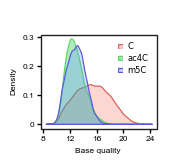

/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 1.5 x 1.22 in image.
/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure/ac4C_base_quality.pdf


In [2]:
#base quality

#read quality plot

from scipy import interpolate
import traceback
#import umap
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from plotnine import *
import pandas as pd
import re
import numpy as np
from statsmodels import robust

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'

c1="#F8766D"
c2="#00BA38"
c3="#619CFF"



def get_mean_quality(file):
    count=0
    mean_quality_list=[]
    next=""
    with open(file) as f:
        for line in f:
            line=line.rstrip()
            if "runid" in line:
                next="sequence"
                continue
            if  line=="+":
                next="quality"
                continue
            if next=="quality":
                base_quality_string=line
                base_quality_list=[ord(char) for char in base_quality_string]
                mean_quality=np.mean(base_quality_list)-33
                mean_quality_list.append(mean_quality)
                count+=1
            if count>10000:
                break
    return mean_quality_list


X=[]
Y=[]

file="/home/wuyou/Projects/Os_AD/data/unmod.fastq"
mean_quality_list=get_mean_quality(file)
X.extend(mean_quality_list)
Y.extend(["C"]*len(mean_quality_list))

file="/home/wuyou/Projects/Os_AD/data/m5C.fastq"
mean_quality_list=get_mean_quality(file)
X.extend(mean_quality_list)
Y.extend(["m5C"]*len(mean_quality_list))


file="/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.fastq"
mean_quality_list=get_mean_quality(file)
X.extend(mean_quality_list)
Y.extend(["ac4C"]*len(mean_quality_list))

print(52)
print(len(X),len(Y))
data=pd.DataFrame(X)
#data["label"]=Y
data.columns=["base quality"]
data["modification"]=Y

#####################################################################################################################
print("plotting")
p1=(ggplot()
    +geom_density(data,aes(x="base quality",color='modification', fill='modification'),alpha=0.3)
    +theme(figure_size=[1.5,1.22],
        axis_text=element_text(size=6,family="Arial",color="black"),
        axis_title_x=element_text(size=6,family="Arial",color="black"),
        axis_title_y=element_text(size=6,family="Arial",color="black"),
        panel_background=element_rect(fill=gray, alpha=0),
        panel_grid_major=element_line(size=0.3, alpha=0,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=6,alpha=0), #change legend title font size
        legend_text = element_text(size=6),
        legend_background=element_rect(size=0.5,alpha=0),
        legend_position=(0.81,0.75), 
        legend_key_size=4) #change legend text font size)))
    +labs(x = "Base quality",y="Density")
    +scale_fill_manual([c1,c2,c3])
   )

print(p1)
"""
p2=(ggplot()+geom_line(data_mod,aes(x="x",y="value",group="variable"),alpha=0.05,color="red")
    +geom_line(data_unmod,aes(x="x",y="value",group="variable"),alpha=0.05,color="black")
    +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0.3,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0.3,color=black),
            panel_border=element_rect(color=black, size=1),
            legend_position = "none",
          figure_size=[6,2.5])+labs(y = "normalized signal")   
)
p2
"""
p1.save('figure/ac4C_base_quality.pdf')


#ggpurb



In [ ]:
#

In [32]:
#python code  mean

from scipy import interpolate
import traceback
import pandas as pd
import re
import numpy as np
from statsmodels import robust


def interp(x):
    """
    Interpolates a given list of values using linear interpolation.

    Args:
        x (list): List of values to be interpolated.

    Returns:
        list: Interpolated values.

    """
    l=len(x)
    y=x
    x=np.linspace(0,l-1,l)
    f=interpolate.interp1d(x,y,kind='slinear')
    x_new=np.linspace(0,l-1,100)
    y_new=f(x_new)
    y_new=np.around(y_new,4)
    return y_new.tolist()

ref_file="/home/wuyou/Projects/Os_AD/data/transcripts.fasta"
ref_dict={}


with open(ref_file) as f:
    seq=""
    for line in f:
        line=line.rstrip()
        if ">" in line:
            seq=""
            chr=line[1:].split(" ")[0]
        else:
            seq+=line
            ref_dict[chr]=seq

ref_chr="LOC_Os05g13620.1.MSUv7.0"
site=349

normalize="median_mad"

motif=ref_dict[chr][site-2:site+3]

print("motif:", motif)

X_mean=[]
X_std=[]
X_median=[]
X_length=[]
X_base_quality=[]
Y=[]

signal_files=["/home/wuyou/Projects/Os_AD/data/unmod.signal.tsv",
              "/home/wuyou/Projects/Os_AD/data/m5C.signal.tsv",
             "/data/wuyou/TandemMod_crop/data/IVET_ac4C/ac4C.signal.tsv"]

label_dict={0:"C",1:"m5C",2:"hm5C"}

for k,signal_file in enumerate(signal_files):
    with open(signal_file) as f:
        count=0
        for line in f:
            line=line.rstrip()
            chr=line.split("\t")[1]
            start=int(line.split("\t")[2])
            seq=line.split("\t")[3]
            signal_string=line.split("\t")[6]
            base_quality_list=line.split("\t")[4].split("|")
            raw_signal=[base_signal_string.split("*") for base_signal_string in signal_string.split("|")]  

            full_length_signal=np.array([x for x in re.split('\*|\|',signal_string)],dtype=int)   #for normlization
            uniq_arr=np.unique(full_length_signal)
            full_length_mean=np.mean(full_length_signal)
            full_length_std=np.std(full_length_signal)



            if start > site or start+len(seq)-3<site or chr != ref_chr:
                continue
            kmer_raw_signal=raw_signal[site-(start-1)-2:site-(start-1)+3]
            kmer_sequence=seq[site-(start-1)-2:site-(start-1)+3]
            if len(kmer_raw_signal)==0:
                continue
            kmer_raw_signal=[np.array(x,dtype=float) for x in kmer_raw_signal]

            if normalize=="zscore":  
                kmer_raw_signal=[(x-full_length_mean)/full_length_std for x in kmer_raw_signal]     #z-score scaling
            elif normalize=="median_mad":  
                kmer_raw_signal = [(x - np.median(uniq_arr)) / float(robust.mad(uniq_arr)) for x in kmer_raw_signal]

            mean=[np.round(np.mean(x),3) for x in kmer_raw_signal]
            std=[np.round(np.std(x),3) for x in kmer_raw_signal]
            median=[np.round(np.median(x),3) for x in kmer_raw_signal]
            length=[len(x) for x in kmer_raw_signal]
            kmer_base_quality=base_quality_list[site-(start-1)-2:site-(start-1)+3]


            x=[]

            if len(kmer_raw_signal) != 5:
                continue

            for i in range(5):      #resample to 500 points

                kmer_raw_signal[i]=interp(np.array(kmer_raw_signal[i],dtype=float))
                x.extend(kmer_raw_signal[i])
            X_mean.append(mean)
            X_std.append(std)
            X_median.append(median)
            X_length.append(length)
            X_base_quality.append(kmer_base_quality)
            Y.append(label_dict[k])
            count+=1
            if count>100:
                break
            

print("data length:",len(Y))

#save data
data=X_mean
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data["sequence"]=[motif]*len(Y)
data=pd.melt(data,id_vars=["label","sequence"])
data.to_csv("data/event_level_features_C_mean.csv")

data=X_std
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_std.csv")

data=X_median
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_median.csv")

data=X_length
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_length.csv")

data=X_base_quality
data=pd.DataFrame(np.array(data,dtype=float)[:,2])   

data["label"]=Y
data=pd.melt(data,id_vars=["label"])
data.to_csv("data/event_level_features_C_base_quality.csv")

motif: AGCAG


KeyboardInterrupt: 

In [29]:
ref_dict

{'LOC_Os01g01010.1.MSUv7.0': 'AGATGAGCTGGTGGGGATGCTCTAAGAGAACGAGAGAAGCACAGAGCAGATAAACCACACCCACAGGCACCACCGTCCTTGTTGGTAATGAAGAAGACGAGACGACGACTTCCCCACTAGGAAACACGACGGAGGCGGAGATGATCGACGGCGGAGAGAGCTACAGAAACATCGATGCCTCCTGTCCAATCCCCCCATCCCATTCGGTAGTTGGATTGAAGACTACCGAATAAGAGAAGCAGGCAGGCAGACAAACCCTTGAACCAAGGAGTCCTCGCTGAGGAAGCTTTGGATCCACGACGCAGCTATGGCCTCCCCGCCCACCAGGCCGCCAGCCACAACCAGCTGACTAGGTAGGCTTCCTAGGTCGCATGCATCATCAGATTTCAATCTCCCTTCGTTCCCTGTCCCTAATCCAATACCAATAGGGAGCAATCAGCTGCTCCTCGACGGCGAGGGAGATGTCGTCGGCCGCGGGCCAAGACAACGGAGATACCGCTGGGGACTACATCAAGTGGATGTGCGGCGCCGGTGGCCGTGCGGGCGGCGCCATGGCCAACCTCCAGCGCGGCGTTGGCTCCCTCGTCCGTGACATTGGCGACCCCTGCCTCAACCCATCCCCCGTTAAGGGGAGCAAAATGCTCAAACCGGAAAAATGGCACACATGTTTTGATAATGATGGAAAGGTCATAGGTTTCCGTAAAGCCCTAAAATTCATTGTCTTAGGGGGTGTGGATCCCACTATTCGAGCTGAAGTTTGGGAATTTCTTCTTGGCTGCTATGCCTTGAGTAGTACCTCAGAGTATAGGAGGAAACTAAGAGCTGTTAGAAGGGAAAAATATCAAATTTTAGTTAGACAGTGCCAGAGCATGCACCCAAGCATTGGTACAGGTGAGCTTGCTTACGCTGTTGGATCAAAGCTAATGGATGTCAGGACTATGTCAAAAGAAACCCACATTGCAGAAGAAGT

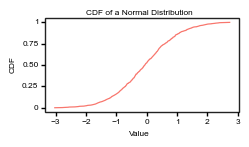

/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:721: PlotnineWarning: Saving 2.5 x 1.22 in image.
/home/wuyou/.conda/envs/TandemMod/lib/python3.7/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: figure/test_cdf.pdf


In [23]:
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_line, aes, labs

# generate simulation data
np.random.seed(0)
data = np.random.normal(0, 1, 1000)
df = pd.DataFrame({'value': data})

# 计算CDF
df = df.sort_values(by='value')
df['cdf'] = np.linspace(0, 1, len(df))

# plot

p=(
    ggplot(df, aes(x='value', y='cdf')) 
    +geom_line(color="#F8766D") 
    +theme(figure_size=[2.5,1.22],
        axis_text=element_text(size=6,family="Arial",color="black"),
        axis_title_x=element_text(size=6,family="Arial",color="black"),
        axis_title_y=element_text(size=6,family="Arial",color="black"),
        plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black",hjust=0.5),
        panel_background=element_rect(fill=gray, alpha=0),
        panel_grid_major=element_line(size=0.3, alpha=0,color=black),
        panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
        panel_border=element_rect(color=black, size=1),
        legend_title = element_text(size=6,alpha=0), #change legend title font size
        legend_text = element_text(size=6),
        legend_background=element_rect(size=0.5,alpha=0),
        legend_position=(0.81,0.75), 
        legend_key_size=4) #change legend text font size)))
    +labs(x = "Value",y="CDF")
    +ggtitle("CDF of a Normal Distribution")
    
)

print(p)
p.save("figure/test_cdf.pdf")